In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import os
import datetime
import warnings
import copy
from scipy.stats import norm, skew
from pandas.core.common import SettingWithCopyWarning


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def parseData(df):
    """
    预处理数据
    """
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 处理pv和uv的空值
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    # 去掉部分特征
    #df.drop('communityName',axis=1, inplace=True)
    df.drop('city',axis=1,inplace=True)
    
    
    agg_func = {
        'buildYear' : ['max','min'],
 
        'pv': ['max','min'],
        'uv': ['max','min'],

    }
    
    agg_trans = df.groupby(['ID']).agg(agg_func)
    agg_trans.columns = [ '_'.join(col).strip() 
                               for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    df = pd.merge(df, agg_trans, on='ID', how='left')
    
    return df

In [4]:
def washData(df_train, df_test):
    """
    清洗数据
    """
    df_train = df_train[df_train['area']<=700]
    df_train = df_train[df_train['tradeMoney']<=40000]
    
    df_train = df_train.drop(df_train[(df_train['region']== 'RG00004') & (df_train['tradeMoney']>30000)].index)
    df_train = df_train.drop(df_train[(df_train['region']== 'RG00009') & (df_train['tradeMoney']>40000)].index)
    
    
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00005') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00011') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00010') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00033') & (df_train['tradeMoney']>14000)].index)
    df_train = df_train.drop(df_train[(df_train['plate']== 'BK00002') & (df_train['tradeMoney']>14000)].index)
    
    
    #df_train = df_train.drop(df_train[(df_train['area']< 100) & (df_train['tradeMoney']>25000)].index)

   
    df_train.drop('ID', axis=1, inplace=True)
    df_test.drop('ID', axis=1,inplace=True)
    
    return df_train, df_test

In [5]:
def feature(df):
    """
    特征
    """
    #houseType
    df['rooms'] = df['houseType'].str.extract(r'(\d+室)', expand=False).apply(lambda x: eval(x.split('室')[0]))
    df['halls'] = df['houseType'].str.extract(r'(\d+厅)', expand=False).apply(lambda x: eval(x.split('厅')[0]))
    df['toilet'] = df['houseType'].str.extract(r'(\d+卫)', expand=False).apply(lambda x: eval(x.split('卫')[0]))

    #卧室面积
    df['roomsarea']=df['area']/df['rooms']

    df['houseToward'].replace(to_replace='暂无数据',value=np.nan,inplace=True)
    df['houseToward'].replace(to_replace='西',value=5,inplace=True)
    df['houseToward'].replace(to_replace='西北',value=6,inplace=True)
    df['houseToward'].replace(to_replace='北',value=4,inplace=True)
    df['houseToward'].replace(to_replace='西南',value=3,inplace=True)
    df['houseToward'].replace(to_replace='东',value=2,inplace=True)
    df['houseToward'].replace(to_replace='东西',value=2,inplace=True)
    df['houseToward'].replace(to_replace='东南',value=1,inplace=True)
    df['houseToward'].replace(to_replace='南',value=0,inplace=True)
    df['houseToward'].replace(to_replace='南北',value=0,inplace=True)
    df['houseToward'] = df['houseToward'].fillna(0).astype(int)
    
    df['rentType'].replace(to_replace='未知方式',value=np.nan,inplace=True)
    df['rentType'].replace(to_replace='整租',value=0,inplace=True)
    df['rentType'].replace(to_replace='合租',value=1,inplace=True)
    df['rentType'] = df['rentType'].fillna(0).astype(int)
    
    
    subway = []
    
    df_subway = list(copy.deepcopy(df['subwayStationNum']))
    for i in df_subway:
        if i >= df['subwayStationNum'].mean():
            subway.append(1)
        else:
            subway.append(0)
    df['subway'] = subway
    
    
    #楼的总面积
    total_square = []
    totalFloor = list(copy.deepcopy(df['totalFloor']))
    area = list(copy.deepcopy(df['area']))
    for i in range(len(totalFloor)):
        temp = totalFloor[i] * area[i]
        total_square.append(temp)
    df['total_square'] = total_square
     
    
    #tradeTime
    df["tradeTime"] = pd.to_datetime(df["tradeTime"])
    df['week'] = df["tradeTime"].dt.weekofyear
    df["month"] = df["tradeTime"].dt.month
    
    
    df['lgarea'] = np.log1p(df['area'])
    #df['AllTradeMoney'] = df['totalTradeMoney'] + df['totalNewTradeMoney']
    '''df['lookNum'] =  df['lookNum'] + 1
    df['lookpv'] = df['lookNum'] / df['pv']
    df['lookuv'] = df['lookNum'] / df['uv']
    df['lookNum'] =  df['lookNum'] - 1 '''
    
    df.drop('houseType', axis=1, inplace=True)
    df.drop('tradeTime', axis=1, inplace=True)
    #df.drop('lookNum', axis=1, inplace=True)
    
     #box-cox转换
    ''' numeric_feats = df.dtypes[df.dtypes != "category" ].index
    print(numeric_feats)
    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    
    skewness = skewness[abs(skewness.Skew)>0.75]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = -0.09
    for feat in skewed_features:
        #all_data[feat] += 1
        if feat != 'tradeMoney':
            df[feat] = boxcox1p(df[feat], lam)'''
        
        
    #region/plate/communityName
    ID = []
    ratio = []
    communityName = df.groupby(['plate'])['communityName']
    for name, group in communityName:
            #print (name)
            #print (type(group))
            count = group.value_counts()
            for i in count.index:
                if count[i] > 0 :
                    #print(i,count[i]/len(group))
                    ID.append(i)
                    ratio.append(count[i]/len(group))
                    
                    
    plate_busStationNum = []
    plate_gymNum = []
    plate_schoolNum = []
    #plate_saleSecHouseNum = []
    #plate_tradeMeanPrice = []
    plate_subwayStationNum = []
    plate_interSchoolNum = []
    plate_privateSchoolNum = []
    #plate_hospitalNum = []
    plate_drugStoreNum = []
    #plate_bankNum = []
    #plate_shopNum = []
    #plate_parkNum=[]
    #plate_mallNum=[]
    #plate_superMarketNum = []





    for index,row in df.iterrows():
        #print(row['plate'])
        plate_busStationNum.append(row['busStationNum'] * ratio[ID.index(row['communityName'])])
        plate_gymNum.append(row['gymNum'] * ratio[ID.index(row['communityName'])])
        plate_schoolNum.append(row['schoolNum'] * ratio[ID.index(row['communityName'])])
        plate_subwayStationNum.append(row['subwayStationNum'] * ratio[ID.index(row['communityName'])])
        plate_interSchoolNum.append(row['interSchoolNum'] * ratio[ID.index(row['communityName'])])
        plate_privateSchoolNum.append(row['privateSchoolNum'] * ratio[ID.index(row['communityName'])])
        plate_drugStoreNum.append(row['drugStoreNum'] * ratio[ID.index(row['communityName'])])
        
    df['plate_busStationNum'] = plate_busStationNum
    df['plate_gymNum'] = plate_gymNum
    df['plate_schoolNum'] = plate_schoolNum
    df['plate_subwayStationNum'] = plate_subwayStationNum
    df['plate_interSchoolNum'] = plate_interSchoolNum
    df['plate_privateSchoolNum'] = plate_privateSchoolNum
    df['plate_drugStoreNum'] = plate_drugStoreNum

    
                    
    

    categorical_feats = ['rentType', 'houseFloor', 'houseDecoration', 'region', 'plate','communityName']
    return df, categorical_feats

In [6]:
def getData(feature):
    """
    获取数据
    """
    train = pd.read_csv('../input/train_data.csv')
    test = pd.read_csv('../input/test_b.csv')
    
    train = parseData(train)
    test = parseData(test)
    
    train, test = washData(train, test)
    
    train, col = feature(train)
    test, col = feature(test)

    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    
    return train, test, target, features, categorical_feats

# 训练模型

In [7]:
train, test, target, features, categorical_feats = getData(feature)

In [26]:
'''train_cat_cols = train.select_dtypes(include=['category']).columns
train[train_cat_cols] = train[train_cat_cols].apply(lambda x: x.cat.codes).replace({-1: np.nan})

test_cat_cols = test.select_dtypes(include=['category']).columns
test[test_cat_cols] = test[test_cat_cols].apply(lambda x: x.cat.codes).replace({-1: np.nan})'''

<Figure size 432x288 with 0 Axes>

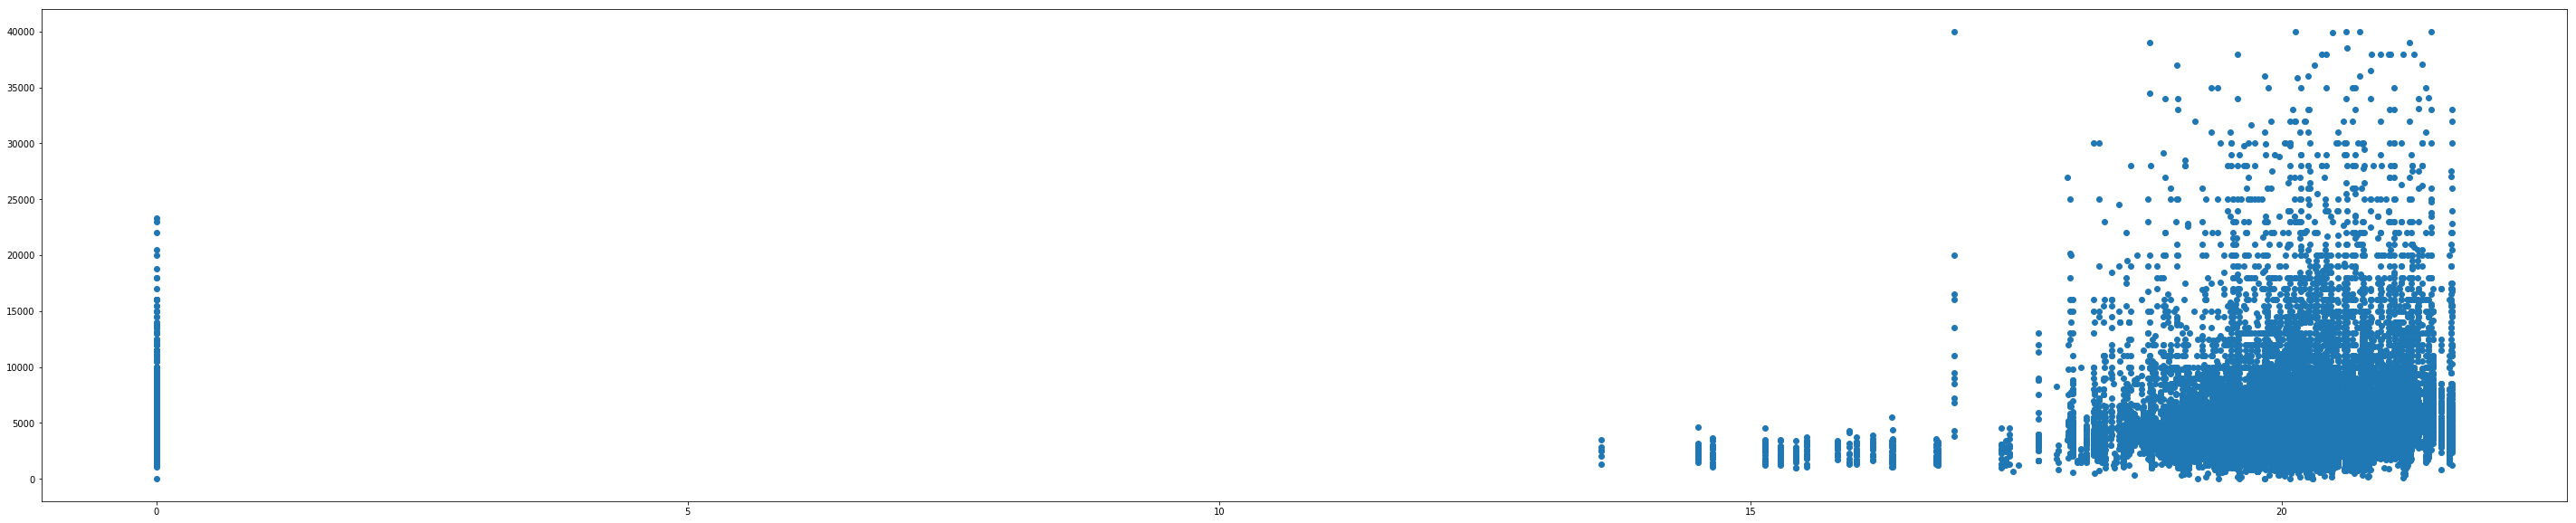

In [145]:
'''plt.clf()
plt.figure(figsize=(50,10))
plt.scatter(x=train.loc[:,'totalTradeMoney'],y=target)
plt.show()'''

<Figure size 432x288 with 0 Axes>

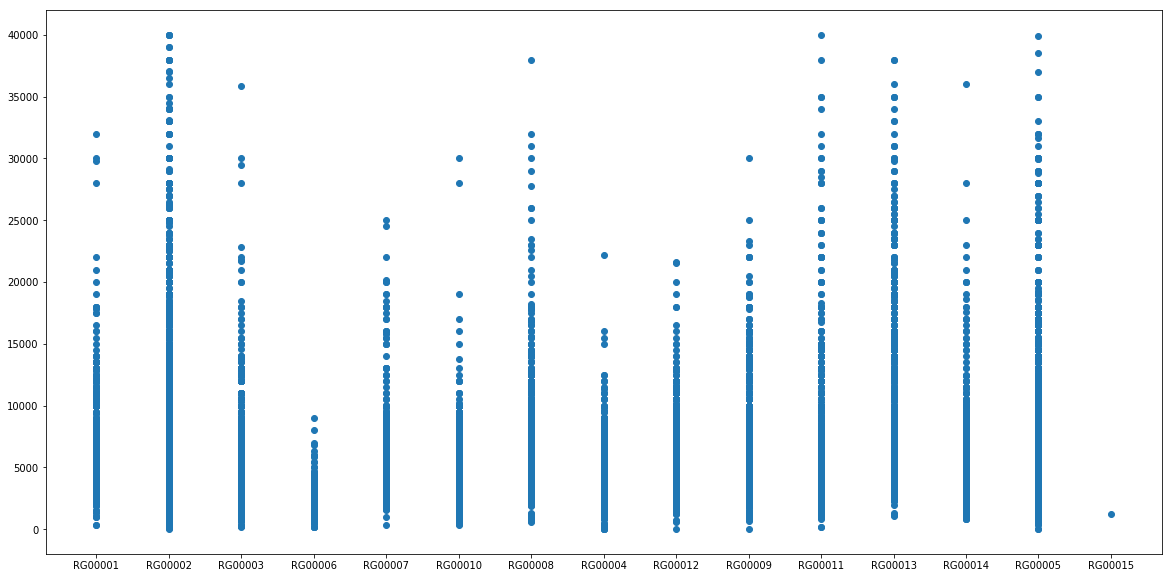

In [100]:
'''plt.clf()
plt.clf()
plt.figure(figsize=(20,10))
plt.scatter(x=train.loc[:,'region'],y=target)
plt.show()'''

In [27]:
'''train.to_csv('train_other.csv',encoding = 'gbk',index=False)
test.to_csv('test_other.csv',encoding = 'gbk',index=False)'''

In [7]:
features

Index(['area', 'rentType', 'houseFloor', 'totalFloor', 'houseToward',
       'houseDecoration', 'communityName', 'region', 'plate', 'buildYear',
       'saleSecHouseNum', 'subwayStationNum', 'busStationNum',
       'interSchoolNum', 'schoolNum', 'privateSchoolNum', 'hospitalNum',
       'drugStoreNum', 'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum',
       'superMarketNum', 'totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice',
       'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea',
       'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum',
       'supplyLandNum', 'supplyLandArea', 'tradeLandNum', 'tradeLandArea',
       'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers',
       'residentPopulation', 'pv', 'uv', 'lookNum', 'buildYear_max',
       'buildYear_min', 'pv_max', 'pv_min', 'uv_max', 'uv_min', 'rooms',
       'halls', 'toilet', 'roomsarea', 'subway', 'total_square', 'week',
       'month', 'lgarea', 'plate_busStationNum', 'plate_gymN

In [24]:
categorical_feats

['rentType',
 'houseFloor',
 'houseDecoration',
 'region',
 'plate',
 'communityName']

In [ ]:
#lgb调参

In [11]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
import optuna
import gc


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def objective(trial):
        num_folds = 5
        
        train_x, train_y = train, target
        #data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
        '''dtrain = lgb.Dataset(train_x, label=train_y)'''
        
       
        lgbm_train = lgb.Dataset(train_x,
                                 train_y,
                                  free_raw_data=False
                                  )
        params = {'objective': 'regression',
                  'metric': 'rmse',
                  'verbosity': -1,
                  "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 0.05),
                  
                  
                  
                  'seed': 2223,
                  "bagging_freq": 1,
                  "bagging_fraction": 0.85,
                  "bagging_seed": 23,
                  "boosting": "gbdt",
                  'num_leaves': trial.suggest_int('num_leaves', 16, 200),
                  'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 16, 64),
                  'min_child_samples' : trial.suggest_int('min_child_samples', 1, 200),
                  'feature_fraction' : trial.suggest_uniform('feature_fraction', 0.001, 1),
                  }

        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
        #folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)


        clf = lgb.cv(
                        params,
                        lgbm_train,
                        metrics=['rmse'],
                        nfold=num_folds,
                        folds=folds.split(train, target),
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100,
                        seed=47
            
                         )
        gc.collect()
        return clf['rmse-mean'][-1]



Using TensorFlow backend.


In [12]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

hist_df = study.trials_dataframe()
hist_df.to_csv("optuna_result_lgbm.csv")

del df
gc.collect()

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[100]	cv_agg's rmse: 1219.23 + 101.661
[200]	cv_agg's rmse: 1147.85 + 100.119
[300]	cv_agg's rmse: 1133.24 + 99.1106
[400]	cv_agg's rmse: 1128.61 + 99.3573
[500]	cv_agg's rmse: 1126.92 + 98.4635
[600]	cv_agg's rmse: 1126.69 + 97.5704


KeyboardInterrupt: 

In [ ]:
#xgb调参

In [16]:
#0.90448
params = {
    'num_leaves': 55,
    'min_data_in_leaf': 18,
    'min_child_samples':196,
    'objective': 'regression',
    'learning_rate': 0.002770254055441383,
    "boosting": "gbdt",
    "feature_fraction":0.6245631583973633,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [12]:
'''#0.90085
params = {
    'num_leaves': 41,
    'min_data_in_leaf': 17,
    'min_child_samples':139,
    'objective': 'regression',
    'learning_rate': 0.012952760113228802,
    "boosting": "gbdt",
    "feature_fraction":0.8079770112855833,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}'''

In [11]:
#np.all(np.isfinite(x))

buildYear             True
drugStoreNum          True
mallNum               True
pv                    True
supplyLandArea        True
area                  True
houseToward           True
shopNum               True
tradeNewMeanPrice     True
privateSchoolNum      True
week                  True
supplyLandNum         True
month                 True
tradeNewNum           True
halls                 True
uv_max                True
buildYear_min         True
totalTradeArea        True
pv_min                True
landMeanPrice         True
hospitalNum           True
uv                    True
residentPopulation    True
saleSecHouseNum       True
buildYear_max         True
subway                True
lgarea                True
supplyNewNum          True
total_square          True
subwayStationNum      True
rooms                 True
tradeLandArea         True
tradeMeanPrice        True
toilet                True
totalTradeMoney       True
interSchoolNum        True
remainNewNum          True
t

In [13]:
#np.all(np.isfinite(target))

True

In [ ]:
#0.90373   #0.90397
#0.90388 
#0.90406 
#0.90421 
#0.90447 
#0.90448 

In [17]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx],categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx],categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)

    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print("fold {}".format(fold_) + "_CV Score: {:<8.5f}".format(r2_score(target.iloc[val_idx], oof_lgb[val_idx])))

    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1527.72	valid_1's rmse: 1560.34
[1000]	training's rmse: 1080.69	valid_1's rmse: 1177.4


KeyboardInterrupt: 

In [31]:
params2 = {
            'gpu_id': 0, 
            #'n_gpus': 2, 
            'objective': 'reg:linear', 
            'eval_metric': 'rmse', 
            'silent': True, 
            'booster': 'gbtree', 
            'n_jobs': 4, 
            'n_estimators': 2500, 
            'tree_method': 'gpu_hist', 
            'grow_policy': 'lossguide', 
            'max_depth': 12, 
            'seed': 538, 
            'colsample_bylevel': 0.9, 
            'colsample_bytree': 0.8, 
            'gamma': 0.0001, 
            'learning_rate': 0.006150886706231842, 
            'max_bin': 16, 
            'max_leaves': 47, 
            'min_child_weight': 40, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9
}


In [11]:
folds = KFold(n_splits=11, shuffle=True, random_state=2333)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

train_cat_cols = train.select_dtypes(include=['category']).columns
train[train_cat_cols] = train[train_cat_cols].apply(lambda x: x.cat.codes).replace({-1: np.nan})

test_cat_cols = test.select_dtypes(include=['category']).columns
test[test_cat_cols] = test[test_cat_cols].apply(lambda x: x.cat.codes).replace({-1: np.nan})

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
   
    X_train, y_train = train.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx], target.iloc[val_idx]
    
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'learning_rate': 0.006150886706231842, 
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train.iloc[trn_idx],target.iloc[trn_idx])
    va_data = xgb.DMatrix(train.iloc[val_idx], target.iloc[val_idx])
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    clf = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=200)
    
    dtest = xgb.DMatrix(test)

    oof_xgb[val_idx] = clf.predict(va_data, ntree_limit=clf.best_ntree_limit)

    print("fold {}".format(fold_) + "_CV Score: {:<8.5f}".format(r2_score(target.iloc[val_idx], oof_xgb[val_idx])))

    predictions_xgb += clf.predict(dtest, ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_xgb)))

fold 0
[0]	train-rmse:5941.56	valid-rmse:5725.86
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[200]	train-rmse:2081.92	valid-rmse:2065.11
[400]	train-rmse:1020.58	valid-rmse:1214.64
[600]	train-rmse:738.596	valid-rmse:1068.34
[800]	train-rmse:645.321	valid-rmse:1039.68
[1000]	train-rmse:605.144	valid-rmse:1031.91
[1200]	train-rmse:576.726	valid-rmse:1027.71
[1400]	train-rmse:549.515	valid-rmse:1023.06
[1600]	train-rmse:524.796	valid-rmse:1019.87
[1800]	train-rmse:502.008	valid-rmse:1017.98
[1999]	train-rmse:479.736	valid-rmse:1016.06
fold 0_CV Score: 0.91031 
fold 1
[0]	train-rmse:5907.35	valid-rmse:6069.29
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 500 rounds.
[200]	train-rmse:2067.97	valid-rmse:2288.54
[400]	train-rmse:1013.04	valid-rmse:1395.21
[600]	train-rmse:734.342	valid-rmse:1222.56
[800]	

In [28]:
'''#删了分数变低
use = []
#删了分数变高
useless = []

for col in train.columns:

    train = pd.read_csv('train_other.csv',encoding = 'gbk')
    test = pd.read_csv('test_other.csv',encoding = 'gbk')
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    for i in columns:
        train [i] = train [i].astype('category')
        test [i] = test [i].astype('category')
    print('drop col:{}'.format(col))
    train=train.drop([col],axis=1)
    test=test.drop([col],axis=1) 
    
    if col in categorical_feats:
        categorical_feats.remove(col)
    
    folds = KFold(n_splits=5, shuffle=True, random_state=2333)

    oof_lgb = np.zeros(len(train))
    predictions_lgb = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx],categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx],categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)

        oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print("fold {}".format(fold_) + "_CV Score: {:<8.5f}".format(r2_score(target.iloc[val_idx], oof_lgb[val_idx])))

        predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
    print('------------------------------------')
    
    print('drop col:{}'.format(col) + " CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))
    
    print('------------------------------------')
    
    if r2_score(target, oof_lgb) >= 0.85814:
        useless.append(col)
    if r2_score(target, oof_lgb) < 0.85814:
        use.append(col)
    
    
    print(useless)
'''

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Categorical'

In [27]:
list(train.columns)

['Unnamed: 0',
 'area',
 'rentType',
 'houseFloor',
 'totalFloor',
 'houseToward',
 'houseDecoration',
 'communityName',
 'region',
 'plate',
 'buildYear',
 'saleSecHouseNum',
 'subwayStationNum',
 'busStationNum',
 'interSchoolNum',
 'schoolNum',
 'privateSchoolNum',
 'hospitalNum',
 'drugStoreNum',
 'gymNum',
 'bankNum',
 'shopNum',
 'mallNum',
 'superMarketNum',
 'totalTradeMoney',
 'totalTradeArea',
 'tradeMeanPrice',
 'tradeSecNum',
 'totalNewTradeMoney',
 'totalNewTradeArea',
 'tradeNewMeanPrice',
 'tradeNewNum',
 'remainNewNum',
 'supplyNewNum',
 'supplyLandNum',
 'supplyLandArea',
 'tradeLandNum',
 'tradeLandArea',
 'landTotalPrice',
 'landMeanPrice',
 'totalWorkers',
 'newWorkers',
 'residentPopulation',
 'pv',
 'uv',
 'lookNum',
 'buildYear_max',
 'buildYear_min',
 'pv_max',
 'pv_min',
 'uv_max',
 'uv_min',
 'rooms',
 'halls',
 'toilet',
 'roomsarea',
 'subway',
 'total_square',
 'week',
 'month',
 'lgarea']

# 特征贡献值

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


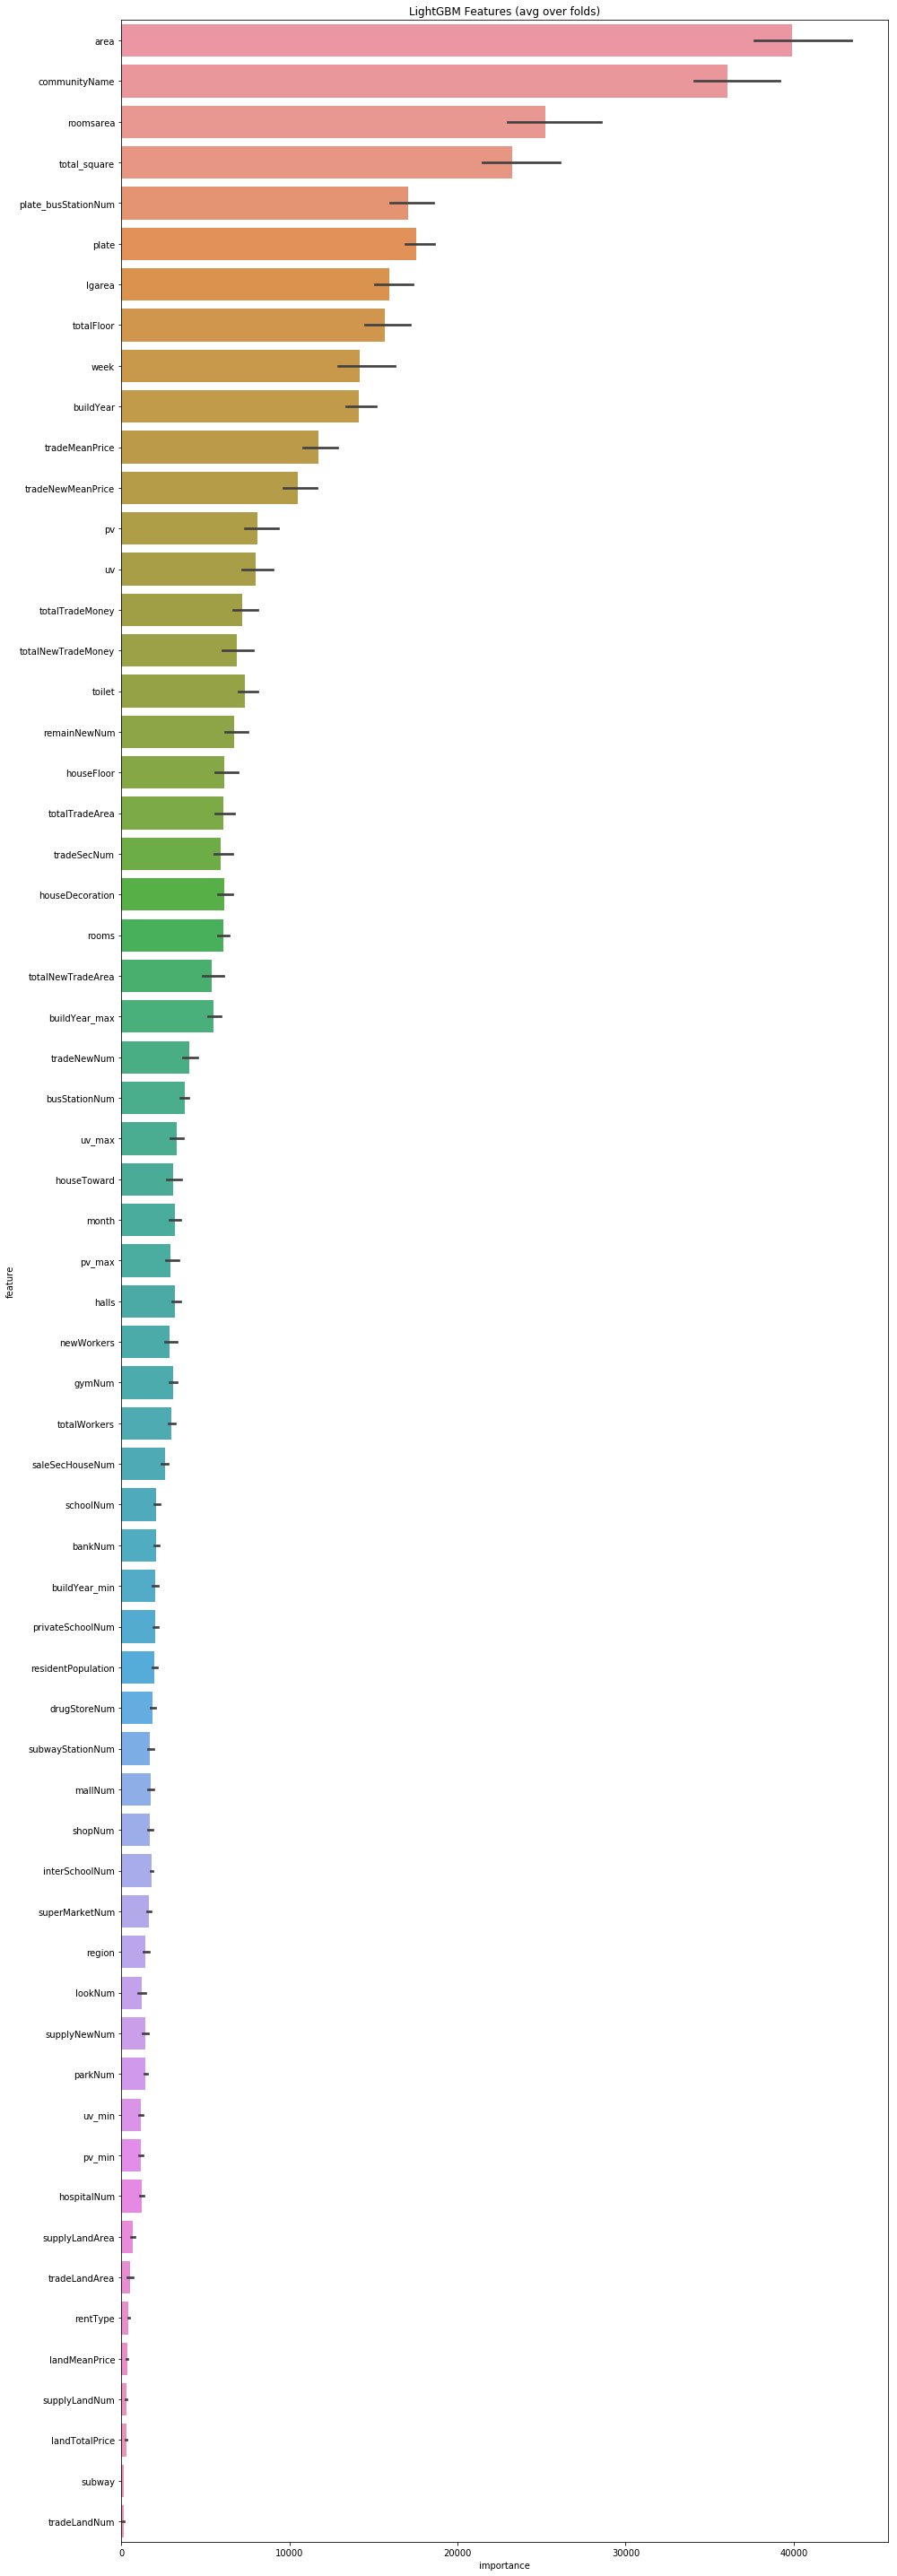

In [12]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# 生成提交数据

In [22]:
pd.DataFrame(oof_lgb).apply(round).to_csv('lgb_oof_preds-0.90448.csv',na_rep='\n',index=False,encoding='utf8',header=False)
pd.DataFrame(predictions_lgb).apply(round).to_csv('lgb_sub_preds-0.90448.csv',na_rep='\n',index=False,encoding='utf8',header=False)

In [12]:
pd.DataFrame(oof_xgb).apply(round).to_csv('xgb_oof_preds-0.89566.csv',na_rep='\n',index=False,encoding='utf8',header=False)
pd.DataFrame(predictions_xgb).apply(round).to_csv('xgb_sub_preds-0.89566.csv',na_rep='\n',index=False,encoding='utf8',header=False)